# Image Recognition Algorithm

<strong>Introduction: Animal Recognition with Oxford-IIIT Pet Dataset</strong>

The aim of this project is to develop a Deep Learning model capable of recognizing and classifying animal images using the Oxford-IIIT Pet Dataset. This dataset includes an extensive collection of images across 37 different categories, covering various breeds of dogs and cats, providing both images and labels necessary for training and evaluating the model.

In the context of this project, advanced machine learning techniques will be explored to address a computer vision task: image classification. We will leverage the capabilities of Convolutional Neural Networks (CNNs) to extract visual features from the images, enabling the model to efficiently distinguish between different animal breeds.

# 1-Load Of Dependencies

### Explanation of Imported Libraries and Modules

Below is a detailed explanation of the libraries and modules used in this project:

 ---

### **1. `import torch`**
 - **What is it?**  
   PyTorch is a deep learning framework that provides tools to build and train machine learning models.  
 - **What does it do?**  
   - Enables tensor operations and computations.  
   - Provides APIs for defining and training neural networks.  
   - Optimizes computations by leveraging GPU acceleration.

 ---

### **2. `from torch import nn`**
 - **What is it?**  
   `torch.nn` is a module in PyTorch that provides building blocks for creating neural networks.  
 - **What does it do?**  
   - Includes classes for layers like `nn.Linear` (fully connected layers) and `nn.Conv2d` (convolutional layers).  
   - Offers activation functions such as `nn.ReLU` and `nn.Softmax`.  
   - Essential for defining model architectures.  

 **Example:**  
 ```python
 model = nn.Linear(10, 5)  # A linear layer with 10 inputs and 5 outputs
 ```

 ---

### **3. `from torch.utils.data import DataLoader`**
 - **What is it?**  
   `DataLoader` is a utility to efficiently iterate over datasets in mini-batches.  
 - **What does it do?**  
   - Loads data in fixed-size batches.  
   - Supports shuffling and multiprocessing to optimize data loading.  
   - Essential for handling large datasets during training.  

 **Example:**  
 ```python
 dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
 ```

 ---

### **4. `from torchvision import datasets`**
 - **What is it?**  
   `torchvision.datasets` is a module in PyTorch that provides predefined datasets for computer vision tasks.  
 - **What does it do?**  
   - Grants access to popular datasets such as **MNIST**, **CIFAR-10**, **FashionMNIST**, etc.  
   - Simplifies dataset loading and preprocessing.  

 **Example:**  
 ```python
 dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
 ```

 ---

### **5. `from torchvision.transforms import ToTensor`**
 - **What is it?**  
   `ToTensor` is a transformation that converts images into tensors.  
 - **What does it do?**  
   - Converts a PIL image or NumPy array into a PyTorch tensor.  
   - Normalizes pixel values to the range `[0, 1]`.  

 **Example:**  
 ```python
 transform = ToTensor()
 ```


In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.segmentation import fcn_resnet50
from torch import optim
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import torch.nn.functional as F

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


# Load And Dawnload Datasets

In [13]:
#First we will define the root in wich the data will be stored
root = './data'

#Downloading training data from open datasets
training_data = OxfordIIITPet(
    root=root,
    split='trainval', 
    target_types='category', 
    transform=ToTensor(), 
    download=True 
)

#Downloading test data from open datasets
test_data = OxfordIIITPet(
    root=root,
    split='test', 
    target_types='category', 
    transform=ToTensor(), 
    download=True 
)

Once data is downloaded and segmentated in train and test we will make a join to have a fulldataset of the pictures wich we will analyze

In [14]:
from torch.utils.data import ConcatDataset

# We combine the training and test data to create a single dataset
dataset = ConcatDataset([training_data, test_data])

# Asocciate the classes to the dataset
if hasattr(training_data, 'classes'):
    dataset.classes = training_data.classes
else:
    dataset.classes = None

# 2-Analysis Of The Data 

### Data Analysis and Understanding

Once the data is loaded, it is essential to analyze it to fully comprehend what we are working with. This includes understanding:

1. **Data Structure:**
   - How the dataset is organized.
   - The relationship between images and their labels or categories.

2. **Data Content:**
   - What information is contained in the dataset.
   - The dimensions, format, and distribution of the images.

3. **Identifying Necessary Adjustments:**
   - Highlighting any required transformations or preprocessing steps (e.g., resizing, normalization) to ensure the proper functioning of the image recognition algorithm.

By performing this analysis, we lay the groundwork for preparing the data effectively and optimizing the model's performance.


In [ ]:
# Verify the number of images in the dataset
print(f"Total number of images in the dataset: {len(dataset)}")

# Retrieve a sample (image and label) from the dataset
sample_image, sample_label = dataset[0]

# Display basic information about the sample
print(f"Image dimensions: {sample_image.shape}")
print(f"Image label: {sample_label} (0 to 36, corresponding to 37 pet categories)")


### Dataset Overview

We have identified that the dataset consists of **7,349 images** classified into **37 categories**. Below is a breakdown of the image dimensions and their significance:

---

#### Image Dimensions: `[3, 500, 394]`

- **1st Number: `3` (Color Channels)**  
  The first dimension corresponds to the **color channels**, indicating that the images are in **RGB format** (Red, Green, Blue). This differs from datasets like FashionMNIST, where the images are in grayscale (single-channel). RGB provides richer information for colored images.

- **2nd Number: `500` (Height in Pixels)**  
  The second dimension represents the **height** of the image, which is **500 pixels**.

- **3rd Number: `394` (Width in Pixels)**  
  The third dimension corresponds to the **width** of the image, which is **394 pixels**.

---

### Additional Notes

Later in the analysis, we will evaluate whether these dimensions are consistent across all images in the dataset or if variations exist. Understanding the standard dimensions will be crucial for preprocessing steps such as resizing or normalizing the images for model training.


## Aleatory Pictures Visualization

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Function to display images with labels
def show_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        # Select a random image
        idx = np.random.randint(len(dataset))
        image, label = dataset[idx]
        
        # Display the image
        axes[i].imshow(image.permute(1, 2, 0))  # Change dimensions from CxHxW to HxWxC
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    plt.show()

# Display 6 random images from the dataset
show_samples(dataset)


### Identifying Image Dimension Variability

During our analysis of the dataset, we observed that the images have **varying dimensions**. This variability can pose challenges for training our model, as convolutional neural networks (CNNs) require all input images to have a consistent size.

---

#### **Why is this a problem?**
1. **Batch Processing Requirements:**
   - CNNs expect all images in a batch to have the same dimensions (e.g., `[channels, height, width]`).
   - Inconsistent dimensions prevent efficient batching and lead to errors during training.

2. **Model Operations:**
   - Operations like convolution and pooling assume a fixed input size. Without uniform dimensions, these operations cannot be performed.

---

#### **Proposed Solution**
To address this issue, we will apply **image transformations** to standardize the dimensions of all images in the dataset. The transformations will include:
- **Resizing:** Adjusting all images to a fixed size (`224x224` pixels).
- **Cropping:** Using techniques like `CenterCrop` to ensure the focus remains on the key parts of the image.
- **Data Augmentation:** Enriching the dataset with techniques like random flips, rotations, or brightness adjustments to improve the model's generalization.

---

### Next Steps
In subsequent steps, we will preprocess the dataset by applying these transformations. This will ensure all images have consistent dimensions, enabling effective training and preventing issues related to input size variability.


## Dimension Analysis

In [ ]:
# Verify if all images have the same size
sizes = set()
for i in range(min(100, len(dataset))):  # Check the first 100 images
    img, _ = dataset[i]
    sizes.add(tuple(img.shape))

print("Image dimensions found:")
for size in sizes:
    print(f"Channels, Height, Width: {size}")



## Category Analysis 

In [ ]:
from torchvision.datasets import OxfordIIITPet

# Get the classes from the dataset using the training set since the dataset does not have a direct attribute for classes
classes = training_data.classes if hasattr(training_data, 'classes') else None

# Display all categories with their indices
if classes:
    print("Index | Category Name")
    print("-" * 30)
    for idx, class_name in enumerate(classes):
        print(f"{idx:5d} | {class_name}")
else:
    print("No classes were found in the dataset.")

### Dataset Categories: Dog and Cat Breeds

Now that we have extracted the names of the categories, we identified that they refer to the **breeds of the animals**, specifically **dogs** and **cats**. 

This insight allows us to conclude that the algorithm will specialize in:
1. **Recognizing images of dogs and cats.**
2. **Classifying the specific breed of each animal.**

This specialization provides a focused scope for our model, ensuring it can perform accurate breed classification within these two categories of animals.


# Distribution Analysis

In [ ]:
# Retrieve labels from the dataset
labels = [label for _, label in dataset]

# Count occurrences of each class
from collections import Counter
class_distribution = Counter(labels)

# Retrieve class names
from torchvision.datasets import OxfordIIITPet

# Ensure that class names are correctly retrieved
classes = dataset.classes if hasattr(dataset, 'classes') else None

if classes:
    # Create the bar chart
    plt.figure(figsize=(20, 8))  # Increment the width for more space

    # Convert class indices to breed names
    breed_names = [classes[label] for label in class_distribution.keys()]
    breed_counts = class_distribution.values()

    # Generate unique colors for each category
    colors = plt.cm.tab20(range(len(breed_names)))  # Tab20 colormap for distinct colors

    # Plot the bar chart using numerical indices on the x-axis
    bars = plt.bar(range(len(breed_counts)), breed_counts, color=colors)
    plt.xticks(range(len(breed_counts)), range(len(breed_counts)), rotation=0)  # Numerical labels on x-axis

    # Add a legend for the breed names
    plt.legend(bars, breed_names, bbox_to_anchor=(1.05, 1), loc='upper left', title="Categories")

    # Add labels and title
    plt.title('Class Distribution in the Pet Dataset')
    plt.ylabel('Number of Examples')
    plt.xlabel('Class Index')

    # Adjust the layout to make better use of space
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.8)  # Adjust margins
    plt.tight_layout()
    plt.show()
else:
    print("No classes were found in the dataset.")


We can observe that the distribution of the data is consistent across categories. This is beneficial for the model because if one category has significantly more data than another, it could lead to an imbalance in the weights assigned by the model to the variables.

A balanced dataset ensures that all categories are equally represented, reducing the risk of bias during the training process and improving the overall performance of the image recognition algorithm.


# Segmentation Analysis

In [ ]:
# Reload the dataset with segmentation
segmentation_dataset = OxfordIIITPet(
    root=root,
    split='trainval',
    target_types='segmentation',  # Change to segmentation
    transform=ToTensor(),
    download=False
)

# Display an example of a segmentation map
image, segmentation_map = segmentation_dataset[0]
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.title("Original Image")

# Show the segmentation map
plt.subplot(1, 2, 2)
plt.imshow(segmentation_map, cmap='gray')
plt.axis('off')
plt.title("Segmentation Map")

plt.show()


### Leveraging Segmentation for Improved Classification

In the dataset, segmentation maps are provided for all the pictures. This is an incredibly powerful asset, as it allows us to train a separate algorithm specifically for segmenting images. 

The segmentation algorithm will play a crucial role in cases where the background makes it difficult for the classification algorithm to recognize patterns. By isolating the object of interest (e.g., the animal), segmentation helps reduce the noise introduced by complex or distracting backgrounds.

### Pipeline Overview
1. **Segmentation Algorithm:**  
   - This will be the first algorithm in the pipeline. It will take an input image and generate a segmented version, isolating the animal from the background.

2. **Classification Algorithm:**  
   - The segmented image will then be analyzed and classified by the second algorithm, which will identify the breed of the animal.

### Benefits of This Approach
- **Improved Accuracy:**  
  By eliminating background noise, the classification algorithm can focus on the object of interest, improving its precision.
- **Modular Design:**  
  Separating segmentation and classification into two distinct stages ensures a more robust and flexible pipeline, capable of handling diverse and challenging images.

This two-step pipeline will leverage the segmentation maps provided in the dataset to enhance the overall performance of the classification task.


# Stadistic Analysis

In [ ]:
import torch
from torchvision.transforms import Resize, Compose

# Transformation to resize images
resize_transform = Resize((224, 224))  # Resize all images to 224x224 pixels

# Resize and take a sample of images
sample_indices = torch.randint(0, len(dataset), (100,))
sample_images = torch.stack([resize_transform(dataset[i][0].unsqueeze(0)).squeeze(0) for i in sample_indices])

# Calculate statistics
print("Dataset statistics:")
print(f"Mean per channel:")
for i, channel in enumerate(['R', 'G', 'B']):
    print(f"{channel}: {torch.mean(sample_images[:,i,:,:]):.4f}")
print(f"\nStandard deviation per channel:")
for i, channel in enumerate(['R', 'G', 'B']):
    print(f"{channel}: {torch.std(sample_images[:,i,:,:]):.4f}")


### Dataset Statistics

The following are the basic statistics for the dataset, calculated per color channel (RGB):

---

### **Data Standardization**
- The dataset has been standardized using the calculated mean and standard deviation for each channel.
- Standardization ensures that pixel intensities are centered around 0 and have a unit variance, improving the stability and efficiency of the model during training.

---

### **Interpretation:**
- The dataset has consistent color distribution across all images.
- The red channel has the highest mean intensity, suggesting warmer tones are slightly more prevalent.
- The standard deviation is similar across all channels, indicating consistent variation in pixel intensities.


# Brigthness&Color Distribution Analysis

In [ ]:
import matplotlib.pyplot as plt

# Analyze brightness and color variability
brightness = []
color_range = []

for i in range(len(dataset)):
    image, _ = dataset[i]

    # Convert tensor to numpy for analysis
    img = image.numpy()

    # Calculate brightness (mean pixel intensity)
    brightness.append(img.mean())

    # Calculate color range (difference between max and min pixel values)
    color_range.append(img.max() - img.min())

# Visualize brightness distribution
plt.figure(figsize=(10, 5))
plt.hist(brightness, bins=30, alpha=0.7, color='blue', label='Brightness')
plt.axvline(x=sum(brightness) / len(brightness), color='red', linestyle='--', label='Mean Brightness')
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize color range distribution
plt.figure(figsize=(10, 5))
plt.hist(color_range, bins=30, alpha=0.7, color='green', label='Color Range')
plt.axvline(x=sum(color_range) / len(color_range), color='red', linestyle='--', label='Mean Color Range')
plt.title("Color Range Distribution")
plt.xlabel("Color Range")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Analysis of Brightness and Color Range Distributions

### **Brightness Distribution**
The **brightness distribution** shows a curve resembling a normal distribution, with most values concentrated around the mean (highlighted by the red dashed line). This indicates that the images have relatively balanced brightness levels, with no significant bias toward extremely bright or dark images. This consistency is beneficial for the model as it ensures that the brightness does not disproportionately affect feature extraction.

---

### Color Range Distribution
The **color range distribution** reveals that the majority of the images have a very narrow color range, clustered near the maximum value, with few outliers. This suggests that the images are well-lit and the colors are represented consistently across the dataset.

---

### **Key Observations**:
1. The brightness levels are well-distributed and follow a normal pattern, minimizing the need for significant adjustments.
2. The color range is tightly packed near the maximum, indicating consistent lighting conditions.

---

### **Implications for the Model**:
These findings suggest that the dataset is well-prepared for training a model.

# 3-Data Transformation  



## Objective
In this block, we prepare the dataset for the hybrid pipeline that dynamically classifies animal breeds based on segmented and non-segmented images. The Oxford-IIIT Pet dataset includes segmentation masks, which we leverage to enhance model performance. This section focuses on applying the necessary transformations to preprocess the data and ensure compatibility with the models in the pipeline.

---

## Purpose of Transformations

### 1. **Handle Segmentation Masks**
- Apply segmentation masks to focus only on the animals and remove irrelevant backgrounds.
- Ensure accurate segmentation for cases where background noise interferes with breed recognition.

### 2. **Data Augmentation**
- Increase dataset diversity by applying transformations such as rotations, flips, and color adjustments.
- Improve model generalization, particularly for scenarios with limited dataset variability.

### 3. **Standardization**
- Normalize images using the dataset’s mean and standard deviation to align with pre-trained models or ensure consistent training.
- Convert pixel values to a range that is effectively processed by deep learning models.

### 4. **Prepare for Hybrid Pipeline**
- Ensure compatibility with two distinct pathways:
  1. **Segmented Images Pathway**: Focus on models trained with images where only the animal is visible.
  2. **Non-Segmented Images Pathway**: Prepare images with intact backgrounds for models optimized for such conditions.

---

## Transformation Pipeline

### For Segmented Images
1. **Mask Application**: Apply segmentation masks provided by the dataset to retain only the animal region.
2. **Augmentation**:
   - Random resizing to introduce variability in object scale.
   - Random rotations and horizontal flips to simulate different orientations.
   - Color jitter to account for lighting and contrast variations.
3. **Normalization**:
   - Use standard mean and standard deviation values (e.g., ImageNet's) for consistency.
   - Normalize pixel values to enhance compatibility with pre-trained or custom models.

### For Non-Segmented Images
1. **Resizing and Cropping**: Standardize image dimensions (e.g., `224x224`) for input compatibility.
2. **Augmentation**:
   - Apply random rotations and horizontal flips to capture variations in background and pose.
   - Simulate real-world variability with subtle transformations.
3. **Normalization**:
   - Normalize pixel values similarly to segmented images.

---

## Why These Transformations?

1. **Utilizing Oxford-IIIT Pet’s Segmentation Masks**:
   - Exploit the dataset's unique feature—segmentation—to enhance the performance of models dealing with segmented data.
2. **Augmentation for Generalization**:
   - Reduce the risk of overfitting by exposing the models to diverse image variations.
3. **Pipeline Compatibility**:
   - Ensure data is tailored for two distinct training paths: segmented and non-segmented images.

---

## Next Steps
With the transformations implemented, the next steps are:
1. Build or select an algorithm to detect noisy backgrounds and assess their impact on breed recognition.
2. Develop a segmentation algorithm (if needed) to generate masks for images with interfering backgrounds.
3. Train models for the two distinct pathways:
   - **Segmented Images**: Leverage the Oxford-IIIT Pet's segmentation data.
   - **Non-Segmented Images**: Train on images with intact backgrounds to handle non-segmented cases effectively.


# Base Transformations

In [23]:
# 1. Base Transformations (common to all models)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size for most modern CNNs
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Values calculated from previous analysis
        std=[0.229, 0.224, 0.225]
    )
])


## Base Transformations (Common to All Models)

### **Description of the Code**
The code defines a series of transformations applied to images to prepare them for use in a deep learning model. These transformations ensure that all images conform to a standard size and scale and are normalized for better model performance.

---

### **Step-by-Step Explanation**
1. **Resize**:
   - **Function**: `transforms.Resize((224, 224))`
   - **Purpose**: Resizes images to a fixed dimension of 224x224 pixels, which is the standard input size for many convolutional neural networks like ResNet and VGG.

2. **Convert to Tensor**:
   - **Function**: `transforms.ToTensor()`
   - **Purpose**: Converts the image from a PIL Image or NumPy array format into a PyTorch tensor. This tensor is of shape `(C, H, W)` (channels, height, width), and pixel values are scaled to the range [0, 1].

3. **Normalize**:
   - **Function**: `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`
   - **Purpose**: Normalizes the image tensor by:
     - Subtracting the mean for each channel (R, G, B).
     - Dividing by the standard deviation for each channel.
   - **Reason**: This standard normalization uses mean and standard deviation values commonly derived from large datasets like ImageNet, improving model generalization and convergence during training.

---

### **Overall Purpose**
The transformation pipeline ensures:
1. Uniformity in image dimensions and pixel value scaling, crucial for consistency in neural network inputs.
2. Preprocessing aligned with pretrained models (e.g., on ImageNet), which optimizes transfer learning setups.


# Background Recognition Transformation

In [24]:
noise_detection_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Light augmentation
    transforms.RandomRotation(10),            # Small rotation to add variety
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5)
    ], p=0.3),                                # Simulate noise
    transforms.RandomErasing(p=0.3),          # Add occlusions to simulate background noise
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Noise Detection Transformations

### **Description of the Code**
This code defines a transformation pipeline designed to augment and preprocess images for noise detection tasks. The augmentations simulate real-world noise and variations to improve model robustness and generalization.

---

### **Step-by-Step Explanation**
1. **Resize**:
   - **Function**: `transforms.Resize((224, 224))`
   - **Purpose**: Resizes images to a fixed dimension of 224x224 pixels, ensuring compatibility with the neural network's input size.

2. **Random Horizontal Flip**:
   - **Function**: `transforms.RandomHorizontalFlip(p=0.5)`
   - **Purpose**: Horizontally flips the image with a 50% probability, introducing variability in the dataset.

3. **Random Rotation**:
   - **Function**: `transforms.RandomRotation(10)`
   - **Purpose**: Rotates the image randomly within a range of ±10 degrees to simulate small angular shifts.

4. **Random Gaussian Blur**:
   - **Function**: `transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3)`
   - **Purpose**: Applies Gaussian blur to the image with a 30% probability, mimicking the effect of noise or camera focus issues.

5. **Random Erasing**:
   - **Function**: `transforms.RandomErasing(p=0.3)`
   - **Purpose**: Randomly removes patches from the image with a 30% probability, simulating occlusions or background noise.

---

### **Overall Purpose**
This transformation pipeline serves two main objectives:
1. **Augmentation**:
   - Adds variability to the dataset with random flips, rotations, blurs, and erasures, ensuring the model learns to detect noise under different conditions.
   - Simulates real-world scenarios where images may have occlusions, blur, or slight rotations.
   
2. **Preprocessing**:
   - Prepares images for deep learning models by resizing, tensor conversion, and normalization to maintain consistency and optimize training performance.


In [25]:
background_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5)
    ], p=0.3),  # Simulate blur in backgrounds
    transforms.RandomErasing(p=0.3),  # Simulate occlusions in background
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Perspective transformations
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


## Background Transformations

### **Description of the Code**
This transformation pipeline applies a series of augmentations specifically designed to enhance the robustness of a model when handling images with varied and potentially noisy backgrounds. The augmentations simulate real-world distortions and variations that might occur in background data.

---

### **Step-by-Step Explanation**
1. **Resize**:
   - **Function**: `transforms.Resize((224, 224))`
   - **Purpose**: Resizes all images to a fixed dimension of 224x224 pixels for consistency with the model's input size.

2. **Random Horizontal Flip**:
   - **Function**: `transforms.RandomHorizontalFlip(p=0.5)`
   - **Purpose**: Introduces variability by flipping images horizontally with a 50% probability.

3. **Random Rotation**:
   - **Function**: `transforms.RandomRotation(15)`
   - **Purpose**: Rotates the image randomly within a range of ±15 degrees to account for slight angular variations.

4. **Color Jitter**:
   - **Function**: `transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)`
   - **Purpose**: Randomly adjusts brightness, contrast, and saturation to simulate different lighting conditions and background variations.

5. **Random Affine Transformation**:
   - **Function**: `transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))`
   - **Purpose**: Applies random translations (up to 10% of the image dimensions) to simulate shifts in the background.

6. **Random Gaussian Blur**:
   - **Function**: `transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3)`
   - **Purpose**: Adds Gaussian blur with a 30% probability to mimic background blur or camera focus issues.

7. **Random Erasing**:
   - **Function**: `transforms.RandomErasing(p=0.3)`
   - **Purpose**: Randomly erases patches of the image with a 30% probability, simulating occlusions in the background.

8. **Random Perspective Transformation**:
   - **Function**: `transforms.RandomPerspective(distortion_scale=0.2, p=0.3)`
   - **Purpose**: Applies perspective distortions to the image with a distortion scale of 0.2 and a 30% probability, mimicking real-world perspective changes.

---

### **Overall Purpose**
1. **Augmentation**:
   - Simulates diverse background conditions such as lighting variations, blurs, occlusions, translations, and perspective distortions.
   - Helps the model generalize better by exposing it to various real-world background noise and transformations.

2. **Preprocessing**:
   - Ensures input consistency and compatibility with the deep learning model by resizing, tensor conversion, and normalization.

### **Key Benefits**
- Prepares the dataset for scenarios with complex or noisy backgrounds.
- Enhances the model's ability to focus on the relevant foreground by reducing reliance on specific background patterns.


# Visualization Of Transformations

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ===========================
# AUXILIARY FUNCTIONS
# ===========================

def convert_to_pil(image):

    if isinstance(image, torch.Tensor):
        return transforms.ToPILImage()(image)
    elif isinstance(image, Image.Image):
        return image
    else:
        raise TypeError(f"Unexpected format: {type(image)}")




def validate_dataset(dataset, segmentation_dataset=None):
    print(f"Dataset size: {len(dataset)}")
    image, label = dataset[0]
    print(f"Example image (dataset): Type {type(image)}, "
          f"Size: {image.size if isinstance(image, Image.Image) else image.shape}, "
          f"Label: {label}")
    if segmentation_dataset:
        print(f"Segmentation dataset size: {len(segmentation_dataset)}")
        seg_image, mask = segmentation_dataset[0]
        print(f"Example mask (segmentation_dataset): Type {type(mask)}, "
              f"Size: {mask.size if isinstance(mask, Image.Image) else mask.shape}")

# ===========================
# TRANSFORM VISUALIZATION
# ===========================

def visualize_base_transforms(dataset, base_transform, num_samples=5):

    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    for i in range(num_samples):
        try:
            idx = np.random.randint(len(dataset))
            image, _ = dataset[idx]
            image = convert_to_pil(image)

            axes[0, i].imshow(image)
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            transformed = base_transform(image)  
            transformed_np = transformed.permute(1, 2, 0).numpy()
            transformed_np = (
                transformed_np * [0.229, 0.224, 0.225] 
                + [0.485, 0.456, 0.406]
            ).clip(0, 1)

            axes[1, i].imshow(transformed_np)
            axes[1, i].set_title("Transformed")
            axes[1, i].axis("off")

        except Exception as e:
            print(f"Error processing index {idx}: {e}")

    plt.tight_layout()
    plt.show()

def visualize_augmentations(dataset, augmentation_transform, num_samples=5, num_augments=4):
    fig, axes = plt.subplots(num_augments + 1, num_samples, figsize=(20, 16))
    for i in range(num_samples):
        try:
            idx = np.random.randint(len(dataset))
            image, _ = dataset[idx]
            image = convert_to_pil(image)

            axes[0, i].imshow(image)
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            for j in range(num_augments):
                augmented = augmentation_transform(image)
                augmented_np = augmented.permute(1, 2, 0).numpy()
                augmented_np = (
                    augmented_np * [0.229, 0.224, 0.225] 
                    + [0.485, 0.456, 0.406]
                ).clip(0, 1)

                axes[j + 1, i].imshow(augmented_np)
                axes[j + 1, i].set_title(f"Augmentation {j + 1}")
                axes[j + 1, i].axis("off")
        except Exception as e:
            print(f"Error processing index {idx}: {e}")

    plt.tight_layout()
    plt.show()


# ===========================
# TRANSFORM DEFINITIONS
# ===========================

# 1) Base transform
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2) Augmentation transform
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



validate_dataset(dataset, segmentation_dataset)
visualize_base_transforms(dataset, base_transform)
visualize_augmentations(dataset, augmentation_transform)



# Purpose of the Code

This code provides tools for **validating**, **visualizing**, and **transforming data** in the context of deep learning tasks. It is primarily designed for classification and segmentation tasks, ensuring data quality and proper preparation before training a model.

---

## 1. Data Validation

### **Objective**
- Verify the consistency of datasets by checking:
  - Dataset sizes.
  - Data types (images and masks).
  - Examples of images, masks, and labels.

### **Purpose**
- Ensure the data meets the requirements for further processing.
- Detect issues during the initial data preparation stage (e.g., incompatible formats, incorrect sizes).

---

## 2. Visualization of Transformations

### **Objective**
- Explore how transformations affect input data through visual examples.
- Visually evaluate the results of transformations such as data augmentation, normalization, and segmentation.

### **Purpose**
- Help understand and debug the transformations applied to the data.
- Ensure the transformed data aligns with the model's expectations.

#### **Included Visualization Types**
1. **Base Transformations**:
   - Displays pairs of original and transformed images using a basic pipeline (e.g., noise detection).

2. **Augmentation**:
   - Visualizes multiple augmented versions of the same image.
   - Useful for evaluating the diversity introduced into the data.

3. **Segmentation Transformations**:
   - Presents a complete workflow from the original image, binarized mask, segmented image, and its transformed version.
   - Specifically designed for projects involving segmentation masks.

---

## 3. Defined Transformations

### **Base Transform**:
- Designed for general tasks like noise detection.
- Includes operations such as rotation, horizontal flipping, Gaussian blur, and random erasing.

### **Augmentation Transform**:
- Focused on augmentation to handle complex background scenarios.
- Includes color adjustments, perspective transformations, and affine translations.

### **Segmented Transform**:
- Applied to segmented images (product of image and mask).
- Includes operations such as color jitter, rotations, and normalization.

---


## **Conclusion**

This set of functions provides an efficient way to validate and explore datasets before training models. It helps identify issues early in the process and ensures that transformations and augmentations are effective and aligned with the project’s objectives.


# Segmentation Recognition Transform


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import matplotlib.colors as mcolors

# ========================
# 1) Transform for the segmented image
# ========================
segmented_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ========================
# 2) Function to crop the image using the mask
# ========================
def crop_image_with_mask(image_pil, mask_pil):
    """
    Multiplies the image by the mask interpreting
    0 as background. Returns a PIL image with a black background.
    """
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image_pil)  # (3,H,W)
    # Mask as a numpy array
    mask_np = np.array(mask_pil)                     # (H,W) in {0,1,2,3}
    # Where mask !=0 => 1, if 0 => 0
    cropped_bin = (mask_np != 0).astype(np.float32)   # (H,W)
    # Convert to tensor
    mask_tensor = torch.from_numpy(cropped_bin).unsqueeze(0)  # (1,H,W)
    # Multiply
    segmented_tensor = image_tensor * mask_tensor
    # Convert back to PIL
    segmented_pil = transforms.ToPILImage()(segmented_tensor)
    return segmented_pil

# ========================
# 3) Load OxfordIIITPet with masks
# ========================
root = "./data"
seg_dataset = OxfordIIITPet(
    root=root,
    split='trainval',
    target_types='segmentation',
    transform=None,
    download=False
)

# ========================
# 4) Visualization in 3 rows
# ========================
def visualize_segmentation(dataset, num_samples=3):

    fig, axes = plt.subplots(nrows=3, ncols=num_samples, figsize=(15, 12))
    n = len(dataset)

    # Discrete colormap for the mask: 0=black, 1=red, 2=green, 3=blue
    cmap = mcolors.ListedColormap(["black", "red", "green", "blue"])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    for i in range(num_samples):
        idx = np.random.randint(n)
        image_pil, mask_pil = dataset[idx]  # (PIL, PIL)

        # (1) Original
        axes[0, i].imshow(image_pil)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # (2) Mask (actual values 0..3)
        mask_np = np.array(mask_pil)
        print(f"Idx={idx} -> Unique mask values: {np.unique(mask_np)}")
        axes[1, i].imshow(mask_np, cmap=cmap, norm=norm)
        axes[1, i].set_title("Mask (0,1,2,3)")
        axes[1, i].axis("off")

        # (3) Crop + Transform
        seg_pil = crop_image_with_mask(image_pil, mask_pil)
        seg_t = segmented_image_transform(seg_pil)  # (3,224,224)
        # Denormalize to visualize
        seg_np = seg_t.permute(1, 2, 0).numpy()
        seg_np = (seg_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
        axes[2, i].imshow(seg_np)
        axes[2, i].set_title("Segmented + Transform")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# ========================
# 5) Call the function
# ========================
visualize_segmentation(seg_dataset, num_samples=3)


# Purpose of the Code

This code demonstrates how to load, visualize, and transform images from the **OxfordIIITPet** dataset with their associated segmentation masks. The focus is on processing images and masks together, cropping the images based on their masks, and applying transformations to prepare the data for machine learning tasks.

---

## Key Components

### 1. **Segmented Image Transformations**
- **Transform Pipeline**: `segmented_image_transform`
  - Includes the following operations:
    - Resizing to `(224, 224)`.
    - Random horizontal flipping.
    - Random rotations up to ±10 degrees.
    - Brightness jitter for slight color adjustments.
    - Conversion to tensor and normalization based on ImageNet statistics.
- **Purpose**: Normalize and augment segmented images to improve model robustness and generalization.

---

### 2. **Cropping Images Using Masks**
- **Function**: `crop_image_with_mask`
  - Multiplies the image by its segmentation mask, treating non-zero mask values as the foreground and setting the background to black.
  - Returns a cropped image with the background removed.
- **Purpose**: Isolate the relevant portions of the image based on the segmentation mask.

---

### 3. **Dataset Loading**
- **Dataset**: `OxfordIIITPet`
  - Loaded using `torchvision.datasets.OxfordIIITPet` with segmentation masks as target labels.
  - **Dataset Annotations**:
    - Masks include pixel-level annotations where:
      - `0`: Background.
      - `1, 2, 3`: Different object classes.

---

### 4. **Visualization**
- **Function**: `visualize_segmentation`
  - Displays three rows of data:
    1. **Original Image**: The raw input image from the dataset.
    2. **Mask**: The segmentation mask visualized with a discrete color map.
    3. **Segmented + Transformed Image**: The cropped image (based on the mask) after applying transformations.
- **Color Mapping**:
  - **Black**: Background (`0`).
  - **Red, Green, Blue**: Object classes (`1, 2, 3`).
- **Purpose**:
  - Helps understand and verify the data preparation process.
  - Ensures alignment between images and their masks.
  - Visualizes the effects of applied transformations.

---

## Workflow

### 1. Define Transformation Pipeline
- Set up a transformation pipeline for cropped segmented images.

### 2. Crop Images Using Masks
- Use the segmentation mask to isolate foreground objects in the image.

### 3. Visualize Results
- Display:
  - The original image.
  - The segmentation mask.
  - The segmented image after applying transformations.

---

## Example Output

When executed, the code produces a grid with three rows:
1. **Original Images**: The unaltered input images from the dataset.
2. **Masks**: Segmentation masks, color-coded to indicate background and object classes.
3. **Segmented + Transformed Images**: Images cropped using the mask and then transformed with the defined pipeline.

---

## Benefits

1. **Preprocessing**:
   - Prepares segmented images for machine learning tasks by isolating relevant content and normalizing inputs.

2. **Data Analysis**:
   - Visualizes segmentation masks alongside their associated images to verify correctness.

3. **Debugging**:
   - Ensures proper alignment between images, masks, and transformations.

4. **Model Robustness**:
   - Applies augmentations to simulate real-world variations, improving model generalization.



# 4-Training Models

# Segmentation Model

In [ ]:
# 1. IMPORTS AND SETUP
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models 
from torchvision.datasets import OxfordIIITPet
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy
import torch.nn.functional as F
import os

# Configuration to avoid warnings
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Trasformations

In [29]:
# 2. TRANSFORMATIONS
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [30]:
# 3. CUSTOM DATASET CLASS
class PetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        mask = transforms.functional.to_tensor(mask)
        mask = transforms.functional.resize(mask, (224, 224), 
                                         interpolation=transforms.InterpolationMode.NEAREST)
        mask = mask.squeeze(0).long()
        return image, mask

### Data Loading

In [31]:
# 4. DATA LOADING FUNCTIONS
def load_datasets():
    root = './data'
    dataset = OxfordIIITPet(
        root=root,
        split='trainval',
        target_types='segmentation',
        transform=None,
        download=True
    )
    
    full_dataset = PetSegmentationDataset(dataset, transform=train_transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    return train_dataset, val_dataset

def create_dataloaders(train_dataset, val_dataset, batch_size=8):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader

### Initialization Of The Model

In [32]:
# 5. MODEL DEFINITION AND INITIALIZATION
def create_segmentation_model(num_classes=3):
    from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights
    
    model = models.segmentation.deeplabv3_resnet50(
        weights=DeepLabV3_ResNet50_Weights.DEFAULT
    )
    
    model.classifier[4] = nn.Sequential(
        nn.Conv2d(256, 128, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout2d(0.6),
        nn.Conv2d(128, 64, 1, bias=False), 
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.6),
        nn.Conv2d(64, num_classes, 1)
    )

    #Regularization
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    return model

def initialize_model():
    model = create_segmentation_model()
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-6,  
        weight_decay=0.01, 
        betas=(0.9, 0.999),
        eps=1e-8
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.2, 
        patience=20,  
        verbose=True,
        min_lr=1e-8
    )
    
    return model, optimizer, scheduler

### Model Definition and Initialization

This section defines and initializes a segmentation model using **DeepLabV3 with ResNet-50** as the backbone, customized for the specific segmentation task.

---

#### 1. Creating the Segmentation Model

The `create_segmentation_model` function customizes the DeepLabV3 model for the task. Here's a detailed breakdown:

- **Base Model:**
  - The backbone is `DeepLabV3_ResNet50` pre-trained on a default dataset (`DeepLabV3_ResNet50_Weights.DEFAULT`) from the `torchvision.models.segmentation` module.
  - This pre-trained model provides robust feature extraction capabilities.

- **Custom Classifier Head:**
  - The default classifier is replaced with a custom one to better fit the target dataset:
    1. **First Layer:**
       - A `Conv2d` layer reduces the feature map to 128 channels.
       - Batch normalization, ReLU activation, and a dropout layer (p=0.6) are applied.
    2. **Second Layer:**
       - Another `Conv2d` layer reduces the feature map to 64 channels, followed by the same normalization, activation, and dropout.
    3. **Output Layer:**
       - A final `Conv2d` layer outputs the required number of segmentation classes (`num_classes`).
  - Dropout is used to improve generalization and prevent overfitting.

- **Weight Initialization:**
  - `Kaiming Normal Initialization` is applied to convolutional layers for better convergence:
    - Weights are initialized using a method that adapts to the number of input features.
    - Biases, if present, are initialized to zero.

---

#### 2. Model Initialization

The `initialize_model` function prepares the model for training by configuring the optimizer and learning rate scheduler:

- **Model Setup:**
  - Calls `create_segmentation_model` to build the model.
  - Transfers the model to the selected device (`cuda` if available).

- **Optimizer:**
  - Uses `AdamW` (Adaptive Moment Estimation with Weight Decay) for optimization:
    - Learning rate: `5e-6`.
    - Weight decay: `0.01` to regularize the model and reduce overfitting.
    - Betas: `(0.9, 0.999)` for momentum calculations.
    - Epsilon: `1e-8` for numerical stability.

- **Learning Rate Scheduler:**
  - A `ReduceLROnPlateau` scheduler is used to dynamically adjust the learning rate:
    - Reduces the learning rate by a factor of `0.2` when validation loss stops improving.
    - `Patience: 20` epochs to avoid premature reduction.
    - Minimum learning rate: `1e-8`.

---

#### Summary

The defined model is well-suited for semantic segmentation tasks with these key features:
- A robust pre-trained backbone (DeepLabV3 with ResNet-50).
- A lightweight and flexible custom classifier head.
- Regularization through dropout and weight decay.
- Adaptive learning rate adjustments for efficient training.


### Training Functions

In [33]:
# 6. TRAINING FUNCTIONS
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.criterion = nn.CrossEntropyLoss(weight=weight, reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs['out'], masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
    return total_loss / num_batches

def validate_with_metrics(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs['out'], masks)
            pred = outputs['out'].argmax(1)
            
            # Calculate IoU
            intersection = ((pred == masks) & (masks > 0)).float().sum()
            union = ((pred > 0) | (masks > 0)).float().sum()
            iou = (intersection + 1e-6) / (union + 1e-6)
            
            # Calculate Dice coefficient
            dice = (2 * intersection + 1e-6) / (pred.sum() + masks.sum() + 1e-6)
            
            total_loss += loss.item()
            total_iou += iou.item()
            total_dice += dice.item()
            num_batches += 1
    
    metrics = {
        'val_loss': total_loss / num_batches,
        'iou': total_iou / num_batches,
        'dice': total_dice / num_batches
    }
    
    return metrics

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    # Initialize loss criterion with class weights
    class_weights = torch.FloatTensor([0.3, 1.0, 1.0]).to(device)
    criterion = FocalLoss(gamma=2, weight=class_weights)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_metrics = []
    patience = 15
    no_improve = 0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Validation phase
        metrics = validate_with_metrics(model, val_loader, criterion)
        val_loss = metrics['val_loss']
        val_losses.append(val_loss)
        val_metrics.append(metrics)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'best_segmentation_model.pth')
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            print("Early stopping triggered")
            break
        
        # Print metrics
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"IoU: {metrics['iou']:.4f}")
        print(f"Dice: {metrics['dice']:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
        print("-" * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics,
        'best_model': best_model
    }

# Training Functions for Semantic Segmentation

This section outlines the key steps and processes involved in training a semantic segmentation model, focusing on custom loss functions, metric evaluation, and training strategies.

---

## 1. Focal Loss
### Purpose:
Focal Loss is designed to handle class imbalance in segmentation tasks by assigning higher weights to difficult-to-classify samples. It reduces the impact of easily classified pixels, allowing the model to focus on challenging regions.

### Key Feature:
- **Gamma parameter:** Adjusts the focus on hard samples.
- **Cross-Entropy Loss foundation:** Ensures compatibility with multi-class segmentation tasks.

---

## 2. Training a Single Epoch
### Purpose:
Performs a single pass over the training dataset, updating model weights based on the computed loss.

### Workflow:
- The model processes each batch of images and ground truth masks.
- Predictions are compared against the targets to compute the loss.
- The optimizer updates model weights through backpropagation.
- Tracks the average loss across all batches for progress monitoring.

---

## 3. Validation with Metrics
### Purpose:
Evaluates the model on a validation dataset to track its generalization performance and calculate critical metrics.

### Metrics:
- **Validation Loss:** Measures the average loss on the validation set.
- **IoU (Intersection over Union):** Evaluates the overlap between predicted and ground truth masks, ensuring accurate segmentation.
- **Dice Coefficient:** Measures the similarity between predicted and ground truth masks, particularly useful for small or unbalanced classes.

### Workflow:
- The model processes the validation data without updating weights.
- IoU and Dice metrics are calculated for each batch, along with the validation loss.
- Averages are computed across all batches to summarize performance.

---

## 4. Full Training Process
### Purpose:
Trains the model over multiple epochs, using the validation set to monitor performance and implement adaptive learning strategies.

### Workflow:
1. **Loss Function Initialization:**  
   - Uses Focal Loss with class weights to mitigate class imbalance.

2. **Training Phase:**  
   - Processes batches of training data to update weights and minimize the training loss.

3. **Validation Phase:**  
   - Evaluates the model using validation metrics, including IoU and Dice Coefficient.

4. **Learning Rate Adjustment:**  
   - The learning rate is dynamically reduced if validation loss plateaus, ensuring efficient convergence.

5. **Model Checkpointing:**  
   - Saves the model with the best validation loss to prevent overfitting and ensure robustness.

6. **Early Stopping:**  
   - Stops training if validation loss doesn't improve over a predefined number of epochs, preventing unnecessary computations and overfitting.

---

## Summary
The training process for semantic segmentation combines advanced loss functions, meaningful metrics, and adaptive learning strategies to optimize model performance. By focusing on both training and validation phases, the process ensures the model generalizes well and achieves high accuracy across diverse datasets. Key features like early stopping and learning rate scheduling further enhance training efficiency and robustness.


In [34]:
# 7. VISUALIZATION FUNCTION
def visualize_results(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Evolution')
    plt.legend()
    plt.show()

In [ ]:
# 8. MAIN EXECUTION
if __name__ == "__main__":
    # Load data
    train_dataset, val_dataset = load_datasets()
    train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)
    
    # Initialize model
    model, optimizer, scheduler = initialize_model()
    
    # Train model
    train_losses, val_losses, best_model = train_model(
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        scheduler
    )
    
    # Visualize results
    visualize_results(train_losses, val_losses)

# Classification Backgroung Model

In [ ]:
# 1. IMPORTS AND SETUP
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy
import torch.nn.functional as F
import os

# Configuration
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


### Transformations


In [ ]:
# 2. TRANSFORMATIONS
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# 3. CUSTOM DATASET CLASS
class BackgroundClassifier(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        
        # Conver mask to binary background VS no Background
        background_mask = (mask == 0).float()
        
        if self.transform:
            image = self.transform(image)
        
        # Clasigiy as complex if theres more than 50% pixels in the background
        background_ratio = background_mask.mean()
        label = torch.tensor(1.0 if background_ratio > 0.5 else 0.0)
        
        return image, label


## Model Training




### Definition Of The Model And Auxiliar Functions


In [ ]:
# 4. MODEL DEFINITION
class BackgroundModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.resnet(x)

def initialize_model():
    model = BackgroundModel().to(device)
    optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )
    return model, optimizer, scheduler

# Background Classification Model

This section focuses on defining and initializing a deep learning model designed to classify the complexity of image backgrounds. The model is implemented using a ResNet-50 backbone and is optimized for binary classification tasks.

---

## 1. Model Architecture
### Purpose:
The `BackgroundModel` is a binary classification model that determines whether an image's background is complex or simple. This decision aids in downstream tasks such as selecting appropriate preprocessing pipelines for images.

### Key Features:
- **ResNet-50 Backbone:**  
  Utilizes a pre-trained ResNet-50 model as a feature extractor. The weights are pre-trained on ImageNet, ensuring robust feature representation.

- **Custom Fully Connected Layer:**  
  - The original fully connected layer is replaced with a sequential layer for binary classification.
  - Includes:
    - A dense layer with 512 units and ReLU activation.
    - Dropout to prevent overfitting.
    - A final dense layer with a single unit and a sigmoid activation for binary output (complex vs. simple background).

---

## 2. Model Initialization
### Purpose:
Prepares the model for training by setting up its components, including the optimizer and learning rate scheduler.

### Workflow:
1. **Model Setup:**
   - The `BackgroundModel` class initializes the architecture and places it on the specified device (CPU/GPU).

2. **Optimizer:**
   - Uses the **Adam optimizer**, which is well-suited for deep learning tasks due to its adaptive learning rates.
   - Includes weight decay (1e-5) to regularize the model and reduce overfitting.

3. **Learning Rate Scheduler:**
   - Implements **ReduceLROnPlateau** to dynamically adjust the learning rate.
   - If the validation loss plateaus for a certain number of epochs (`patience=5`), the learning rate is reduced by a factor (`factor=0.1`).
   - Ensures efficient convergence without manual tuning.

---

## Summary
The background classification model leverages the power of transfer learning with ResNet-50 to achieve efficient feature extraction while customizing the architecture for binary classification. The initialization process incorporates robust optimization and learning rate adjustment strategies, ensuring that the model is both efficient and adaptable during training. These features collectively make the model well-suited for distinguishing complex from simple backgrounds in images.



### Training Functions


In [ ]:
# 5. TRAINING FUNCTIONS
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
    return total_loss / len(val_loader), correct / total

# Training Functions for Background Classification Model

This section outlines the functions responsible for training and validating the background classification model. These functions handle data processing, loss computation, performance metrics, and optimization during each epoch.

---

## 1. Training Function: `train_epoch`

### Purpose:
To train the model for a single epoch using the provided training dataset and update the model's parameters based on the computed loss.

### Key Steps:
1. **Model Training Mode:**  
   - The model is set to training mode, enabling dropout and other training-specific behaviors.

2. **Batch Processing:**
   - For each batch of images and labels in the `train_loader`:
     - Images and labels are moved to the appropriate device (CPU/GPU).
     - Forward pass: Predictions are made using the model.
     - Loss calculation: The binary cross-entropy loss between the predictions and true labels is computed.
     - Backpropagation: Gradients are calculated and weights are updated using the optimizer.

3. **Metrics Calculation:**
   - Loss is accumulated over all batches to calculate the average training loss.
   - Accuracy is determined by comparing predictions (thresholded at 0.5) with true labels.

### Outputs:
- **Average Loss:** The mean loss across all batches.
- **Accuracy:** The proportion of correctly predicted labels.

---

## 2. Validation Function: `validate`

### Purpose:
To evaluate the model's performance on the validation dataset without updating the model's parameters. This provides an indication of how well the model generalizes to unseen data.

### Key Steps:
1. **Model Evaluation Mode:**  
   - The model is set to evaluation mode, disabling dropout and other training-specific behaviors.

2. **Batch Processing:**
   - For each batch of images and labels in the `val_loader`:
     - Images and labels are moved to the appropriate device.
     - Forward pass: Predictions are made using the model.
     - Loss calculation: Binary cross-entropy loss is computed between predictions and true labels.

3. **Metrics Calculation:**
   - Loss is accumulated over all batches to calculate the average validation loss.
   - Accuracy is determined by thresholding predictions and comparing them with true labels.

### Outputs:
- **Average Loss:** The mean loss across all validation batches.
- **Accuracy:** The proportion of correctly predicted labels.

---

## Summary:
These training and validation functions ensure efficient optimization of the model during training and robust evaluation during validation. They calculate key metrics such as loss and accuracy, providing essential feedback for model improvement. This systematic approach aids in monitoring the model's learning progress and its generalization ability to unseen data.




### Configuration&Inizialization


In [ ]:
# 6. MAIN TRAINING LOOP
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    criterion = nn.BCELoss()
    best_val_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'best_background_classifier.pth')
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_model': best_model
    }

# Main Training Loop for Background Classification Model

This section details the main training loop, which orchestrates the entire process of training and validating the background classification model over multiple epochs. The loop ensures systematic model improvement, validation, and saving of the best-performing model.

---

## Purpose:
The main training loop coordinates:
1. Training the model on the training dataset.
2. Evaluating the model on the validation dataset.
3. Adjusting learning rates dynamically using a scheduler.
4. Saving the best model based on validation accuracy.

---

## Key Components:

### 1. **Loss Function:**
   - **Binary Cross-Entropy Loss (`BCELoss`)** is used to measure the difference between predicted probabilities and true binary labels. It is appropriate for binary classification tasks.

---

### 2. **Epochs:**
   - The loop iterates over the specified number of epochs (`num_epochs`), where each epoch involves:
     - A training phase using the `train_epoch` function.
     - A validation phase using the `validate` function.

---

### 3. **Metrics and Tracking:**
   - **Training Metrics:** Average training loss and accuracy are calculated for each epoch.
   - **Validation Metrics:** Average validation loss and accuracy are calculated to monitor model performance on unseen data.
   - Metrics are stored in lists (`train_losses`, `val_losses`, `train_accs`, `val_accs`) for further analysis and visualization.

---

### 4. **Learning Rate Scheduling:**
   - A learning rate scheduler dynamically adjusts the learning rate based on validation loss. This helps the optimizer converge effectively by reducing the learning rate when the loss plateaus.

---

### 5. **Best Model Saving:**
   - The model's weights are saved to a file (`best_background_classifier.pth`) whenever the validation accuracy improves. This ensures that the best-performing model is preserved for later use.

---

### 6. **Early Stopping (Optional):**
   - Although not explicitly implemented, early stopping could be added to halt training when validation performance stops improving for several consecutive epochs.

---

## Outputs:
The function returns a dictionary containing:
- **Training Losses:** List of average training losses for all epochs.
- **Validation Losses:** List of average validation losses for all epochs.
- **Training Accuracies:** List of training accuracies for all epochs.
- **Validation Accuracies:** List of validation accuracies for all epochs.
- **Best Model:** The weights of the model that achieved the highest validation accuracy.

---

## Summary:
The main training loop is the core of the training process, ensuring that the model learns effectively while monitoring its ability to generalize to unseen data. It balances performance optimization with model evaluation and provides mechanisms for saving the best model for deployment or further analysis.


### Visualization

In [ ]:
# 7. VISUALIZATION
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['val_accs'], label='Val Acc')
    ax2.set_title('Accuracies')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()


### Training

In [ ]:
# 8. MAIN EXECUTION
if __name__ == "__main__":
    # Load dataset
    dataset = OxfordIIITPet(
        root="./data",
        split="trainval",
        target_types="segmentation",
        transform=None,
        download=True
    )
    
    # Create custom dataset
    full_dataset = BackgroundClassifier(dataset, transform=train_transform)
    
    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # Initialize model
    model, optimizer, scheduler = initialize_model()
    
    # Train model
    history = train_model(model, train_loader, val_loader, optimizer, scheduler)
    
    # Plot results
    plot_results(history)

---

# Recognition Algorythim Of Segmentated Images

In [ ]:
# 1. IMPORTS AND SETUP
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy
import torch.nn.functional as F
import os

# Configuración
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Transformations And Functions

In [ ]:
# 2. TRANSFORMATIONS
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# 3. CUSTOM DATASET CLASS
class SegmentedPetClassifier(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]
        
        # Apply the mask to the picture
        image_array = np.array(image)
        mask_array = np.array(mask)
        
        # Create segmented image
        segmented_image = image_array.copy()
        segmented_image[mask_array == 0] = 0  # Fondo a negro
        segmented_image = Image.fromarray(segmented_image)
        
        if self.transform:
            segmented_image = self.transform(segmented_image)
        
        # Obtain labels
        label = self.dataset.classes.index(self.dataset.class_to_idx[idx])
        
        return segmented_image, label

### Definition Of The Model And Auxiliar Functions

In [ ]:
# 4. MODEL DEFINITION
class SegmentedClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Use EfficientNer as backbone
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        # Modifiy the las layer
        num_ftrs = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

def initialize_model(num_classes):
    model = SegmentedClassifierModel(num_classes).to(device)
    
    # Use AdamW with different learning rates
    optimizer = AdamW([
        {'params': model.backbone.features.parameters(), 'lr': 1e-5},
        {'params': model.backbone.classifier.parameters(), 'lr': 1e-4}
    ], weight_decay=0.01)
    
    # Use Scheduler with CosineAnnealingWarmRestarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # First cycle length
        T_mult=2,  # Multiplicative factor for cycle length
        eta_min=1e-6  # Minimum learning rate
    )
    
    return model, optimizer, scheduler

Model Definition and Initialization

This section outlines the implementation of an image classification model designed to work with segmented images, focusing on leveraging a robust backbone architecture, fine-tuned optimization, and advanced learning rate scheduling.

---

## Purpose:
To classify segmented images accurately by leveraging the EfficientNet architecture and implementing a tailored optimization strategy to ensure optimal learning across both the feature extraction and classification components of the model.

---

## Key Components:

### 1. **Model Architecture:**
   - **Backbone:** EfficientNet-B0 is utilized as the feature extractor for its proven effectiveness in handling complex image features.
   - **Modified Classifier:**
     - The final classification layers of EfficientNet are replaced with a custom sequential block.
     - Includes dropout for regularization and fully connected layers to map features to the target number of classes.

---

### 2. **Model Initialization:**
   - The model is initialized with specified parameters:
     - **Backbone Pretrained Weights:** EfficientNet-B0 is loaded with pre-trained weights (`EfficientNet_B0_Weights.DEFAULT`) for robust feature extraction.
     - **Device:** The model is transferred to the computation device (`GPU` or `CPU`).

---

### 3. **Optimizer:**
   - **AdamW Optimizer:** 
     - Selected for its ability to handle weight decay effectively, ensuring stable and efficient learning.
     - **Differentiated Learning Rates:**
       - Backbone parameters use a lower learning rate (`1e-5`) to preserve pre-trained features.
       - Classifier parameters use a higher learning rate (`1e-4`) to allow faster adaptation to the specific classification task.

---

### 4. **Learning Rate Scheduler:**
   - **Cosine Annealing with Warm Restarts (`CosineAnnealingWarmRestarts`):**
     - Gradually decreases the learning rate in a cosine pattern to simulate warm restarts.
     - Key Parameters:
       - **`T_0`:** Number of iterations for the first learning rate cycle.
       - **`T_mult`:** Factor by which the number of iterations for subsequent cycles is multiplied.
       - **`eta_min`:** Minimum learning rate during the cycle.

---

## Advantages of the Approach:
1. **Feature Extraction Efficiency:** Leveraging EfficientNet-B0 ensures high-quality feature extraction, which is crucial for handling segmented images.
2. **Regularization:** Dropout layers help reduce overfitting in the classification head.
3. **Optimized Learning Rates:** Differentiated learning rates allow the model to fine-tune specific parts effectively without disrupting pre-trained features.
4. **Learning Rate Dynamics:** The cosine annealing scheduler enhances convergence and minimizes overfitting by simulating restarts during training.

---

## Summary:
This model is designed to classify segmented images efficiently using state-of-the-art backbone architecture and advanced training techniques. It combines pre-trained knowledge with task-specific adaptations to optimize both feature extraction and classification, ensuring robust performance on segmented datasets.


## Model Training

### Trainment Function

In [ ]:
# 5. TRAINING FUNCTIONS
def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Use mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    return total_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(val_loader), 100. * correct / total

# Training Functions for Segmented Image Classification

This section defines the training and validation functions for the segmented image classification model, incorporating techniques like mixed precision training to enhance computational efficiency and accuracy.

---

## Purpose:
To optimize the training and validation processes by efficiently computing loss and accuracy, leveraging GPU capabilities, and maintaining model stability during gradient updates.

---

## Key Functions:

### 1. **Training Function (`train_epoch`):**
   - **Objective:** To perform a single epoch of training, updating model weights based on the training dataset.
   - **Key Steps:**
     1. **Mixed Precision Training:** Uses `torch.cuda.amp.autocast()` for reduced memory usage and faster computation while maintaining accuracy.
     2. **Loss Calculation:** Computes loss using the specified criterion (e.g., CrossEntropyLoss).
     3. **Gradient Scaling:** Scales gradients using `torch.cuda.amp.GradScaler` to prevent underflow during backpropagation.
     4. **Parameter Updates:** Gradients are applied to optimize the model via the optimizer.
     5. **Metrics Computation:** Tracks total loss and calculates accuracy by comparing predictions with ground-truth labels.
   - **Returns:** Average loss and accuracy for the epoch.

---

### 2. **Validation Function (`validate`):**
   - **Objective:** To evaluate model performance on the validation dataset without updating model weights.
   - **Key Steps:**
     1. **Evaluation Mode:** Sets the model to evaluation mode (`model.eval()`) to disable dropout and other training-specific behaviors.
     2. **Loss Calculation:** Computes loss for each batch to evaluate model performance.
     3. **Metrics Computation:** Tracks total loss and calculates accuracy by comparing predictions with ground-truth labels.
   - **Returns:** Average loss and accuracy on the validation dataset.

---

## Advanced Features:

1. **Mixed Precision Training:**
   - Significantly reduces memory usage and speeds up computation.
   - Achieved via `torch.cuda.amp.autocast()` and `torch.cuda.amp.GradScaler`.
   - Particularly effective for large-scale datasets or high-resolution images.

2. **Accuracy Tracking:**
   - Calculates the percentage of correct predictions in both training and validation phases.
   - Provides a clear measure of model performance.

3. **Device Compatibility:**
   - Ensures all tensors (`images`, `labels`) and the model operate on the specified device (`GPU` or `CPU`).

---

## Metrics Tracked:
- **Loss:** Measures how well the model predicts labels compared to the ground truth.
- **Accuracy:** Indicates the proportion of correct predictions, providing an intuitive understanding of performance.

---

## Summary:
These training functions integrate advanced computational techniques to optimize performance and efficiency during model training and validation. They ensure robust updates to the model while tracking metrics that are critical for evaluating progress and identifying areas for improvement.


### Configuration&Inizialization

In [ ]:
# 6. TRAINING LOOP
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    best_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update scheduler
        scheduler.step()
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'best_segmented_classifier.pth')
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.2e}")
        print("-" * 50)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_model': best_model
    }

# Training Loop for Segmented Image Classification

This section describes the complete training loop used to optimize the segmented image classification model. It incorporates advanced training techniques such as mixed precision, dynamic learning rate scheduling, and regular validation for tracking progress.

---

## Purpose:
To train the segmented classification model iteratively across multiple epochs, evaluate performance on a validation dataset, and save the best-performing model for future use.

---

## Key Components:

### 1. **Loss Function (`CrossEntropyLoss`):**
   - Used to measure the error between predicted class probabilities and ground-truth labels.
   - Suitable for multi-class classification tasks.

### 2. **Gradient Scaler:**
   - Enables **mixed precision training** using `torch.cuda.amp.GradScaler` to handle gradient scaling.
   - Prevents numerical underflows during backpropagation, especially when using lower-precision (e.g., FP16) computations.

### 3. **Learning Rate Scheduler (`CosineAnnealingWarmRestarts`):**
   - Adjusts the learning rate dynamically to enhance training stability and convergence.
   - The learning rate oscillates in cycles, restarting periodically for better optimization.

---

## Training Process:
1. **Epoch Initialization:**
   - The loop iterates over the specified number of epochs (`num_epochs`).
   - Metrics for loss and accuracy are reset at the start of each epoch.

2. **Training Phase:**
   - The `train_epoch` function trains the model on the training dataset:
     - Forward pass: Generates predictions for input images.
     - Loss computation: Calculates loss using `CrossEntropyLoss`.
     - Backward pass: Updates model parameters using scaled gradients (`GradScaler`).
     - Metrics tracking: Aggregates loss and accuracy metrics across all batches.

3. **Validation Phase:**
   - The `validate` function evaluates the model on the validation dataset:
     - Calculates validation loss and accuracy without updating model parameters.
     - Provides insights into the model's generalization performance.

4. **Learning Rate Update:**
   - The learning rate is adjusted after each epoch based on the `scheduler`.

5. **Best Model Saving:**
   - If the validation accuracy improves over the best recorded accuracy, the current model's state is saved as the "best model."

---

## Metrics Tracked:
- **Training Loss:** Measures the error on the training dataset.
- **Validation Loss:** Measures the error on the validation dataset.
- **Training Accuracy:** Proportion of correct predictions on the training dataset.
- **Validation Accuracy:** Proportion of correct predictions on the validation dataset.

---

## Early Stopping and Model Saving:
- The loop saves the best-performing model (based on validation accuracy) to prevent overfitting and ensure the highest generalization capability.
- The saved model is stored as `best_segmented_classifier.pth`.

---

## Outputs:
- **Training and Validation Losses:** Visualize convergence during training.
- **Training and Validation Accuracies:** Monitor performance improvements.
- **Best Model Weights:** Exported for deployment or further evaluation.

---

## Summary:
The training loop orchestrates the entire optimization process, integrating advanced techniques like mixed precision, learning rate scheduling, and validation tracking. This ensures efficient training while capturing the best-performing model for deployment.


### Training

In [ ]:
# 8. MAIN EXECUTION
if __name__ == "__main__":
    # Load dataset
    dataset = OxfordIIITPet(
        root="./data",
        split="trainval",
        target_types="segmentation",
        transform=None,
        download=True
    )
    
    # Create custom dataset
    full_dataset = SegmentedPetClassifier(dataset, transform=train_transform)
    
    # Split dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=32, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize model
    model, optimizer, scheduler = initialize_model(num_classes=37)  # 37 clases en Oxford Pets
    
    # Train model
    history = train_model(model, train_loader, val_loader, optimizer, scheduler)
    
    # Plot results
    plot_results(history)  # Usar la misma función de visualización que antes

# Recognition Algorythim Of Non-Segmentated Images

In [ ]:
# 1. IMPORTS AND SETUP
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy
import torch.nn.functional as F
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Transformations And Functions

In [14]:
# 2. TRANSFORMATIONS
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
# 3. CUSTOM DATASET CLASS
class StandardPetClassifier(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        
        if isinstance(image, Image.Image):
            if self.transform:
                image = self.transform(image)
            else:
                image = self.to_tensor(image)
        
        target = torch.tensor(target, dtype=torch.long)
        
        return image, target

## Model Training

### Definition Of The Model And Auxiliar Functions

In [16]:
# 4. MODEL DEFINITION
class PetBreedClassifier(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        
        num_ftrs = self.backbone.classifier[1].in_features
        
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

def initialize_model():
    model = PetBreedClassifier(num_classes=37).to(device)
    # Freeze all the base layers of the model EficcientNet
    for param in model.backbone.features.parameters():
        param.requires_grad = False

    
    optimizer = AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.01
    )
    
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )
    
    return model, optimizer, scheduler

# Model Definition for Non-Segmented Image Classification

This section focuses on defining the architecture and initialization process for a deep learning model used in the classification of non-segmented pet images. The model is built on the EfficientNet backbone with modifications tailored to the task.

---

## Purpose:
To classify pet breeds directly from non-segmented images, leveraging the powerful feature extraction capabilities of the EfficientNet architecture.

---

## Key Components:

### 1. **Model Architecture (`PetBreedClassifier`):**
   - **Backbone:** 
     - Uses EfficientNet-B0 as the base architecture.
     - Pre-trained weights (`EfficientNet_B0_Weights.DEFAULT`) provide strong initial feature representations.
   - **Modified Classifier:**
     - Replaces the original EfficientNet classification layer with a custom Sequential block:
       - **512-Neuron Fully Connected Layer:** Adds capacity to capture complex patterns.
       - **ReLU Activation:** Introduces non-linearity.
       - **Dropout Layers (p=0.3):** Reduces overfitting by randomly dropping neurons during training.
       - **Output Layer:** Maps features to the `num_classes` output (37 pet breeds in this case).

---

### 2. **Layer Freezing:**
   - Freezes the parameters of the EfficientNet backbone's feature extraction layers to:
     - Prevent overwriting pre-trained weights.
     - Focus training on the new classifier layers.
   - Only the classifier parameters are trainable, reducing computational cost and overfitting risk.

---

### 3. **Optimizer (`AdamW`):**
   - **Weight Decay:** Regularizes the model to prevent overfitting by penalizing large weights.
   - **Learning Rate:** Set to `1e-4` for a stable optimization process.

---

### 4. **Learning Rate Scheduler (`CosineAnnealingWarmRestarts`):**
   - Dynamically adjusts the learning rate during training:
     - **Cyclic Warm Restarts (`T_0=10`):** Starts with an initial cycle of 10 epochs.
     - **Cycle Multiplier (`T_mult=2`):** Subsequent cycles double in length.
     - **Minimum Learning Rate (`eta_min=1e-6`):** Prevents the learning rate from reaching zero.
   - Promotes efficient convergence while escaping local minima.

---

## Initialization Process:
1. **Model Creation:** 
   - Initializes the `PetBreedClassifier` with the specified number of classes (37 pet breeds).
   
2. **Feature Freezing:** 
   - Freezes the EfficientNet backbone's feature extraction layers to preserve pre-trained knowledge.

3. **Optimizer and Scheduler Setup:**
   - Configures the `AdamW` optimizer to update trainable parameters.
   - Configures the cosine annealing scheduler to dynamically manage the learning rate.

---

## Advantages of This Design:
- **Transfer Learning:** Leverages pre-trained weights for better feature extraction.
- **Customization:** Tailors the classification head to the specific dataset.
- **Efficient Training:** Freezing layers reduces computational overhead and the risk of overfitting.
- **Dynamic Learning Rates:** Encourages smooth convergence and mitigates issues with local minima.

---

## Summary:
The `PetBreedClassifier` model is optimized for classifying non-segmented pet images, balancing efficiency and accuracy through transfer learning, feature freezing, and dynamic learning rate scheduling.


### Trainment Function

In [17]:
# 5. TRAINING FUNCTIONS
def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'Batch: {batch_idx}/{len(train_loader)} | '
                  f'Loss: {loss.item():.4f} | '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(37))
    class_total = list(0. for i in range(37))
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            c = predicted.eq(labels)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    class_acc = {}
    for i in range(37):
        if class_total[i] > 0:
            class_acc[i] = 100 * class_correct[i] / class_total[i]
    
    return {
        'val_loss': total_loss / len(val_loader),
        'val_acc': 100. * correct / total,
        'class_acc': class_acc
    }

### Configuration&Inizialization

In [ ]:
# 6. TRAINING LOOP
def train_model(model, train_loader, val_loader, optimizer, scheduler, class_weights, num_epochs=50):
    # Usar los pesos de clase en la función de pérdida
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scaler = torch.cuda.amp.GradScaler()
    
    best_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 60)
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_metrics = validate(model, val_loader, criterion)
        val_loss = val_metrics['val_loss']
        val_acc = val_metrics['val_acc']
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update scheduler
        scheduler.step()
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
            }, 'Best_Non-Segmented_Clasiffier.pth')
        
        # Print epoch results
        print(f"\nTraining Loss: {train_loss:.4f} | Training Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.2f}%")
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.2e}")
        
        # Print per-class accuracy for some classes
        class_acc = val_metrics['class_acc']
        print("\nPer-class accuracy for selected breeds:")
        for i in range(min(5, len(class_acc))):
            print(f"Class {i}: {class_acc[i]:.2f}%")
        
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_model': best_model,
        'final_class_acc': val_metrics['class_acc']
    }


# Training Functions for Non-Segmented Image Classification

This section describes the training and validation functions used to optimize the `PetBreedClassifier` model for classifying non-segmented pet images. These functions include training one epoch, validating the model's performance, and tracking metrics like class-wise accuracy.

---

## Key Components:

### 1. **Epoch Training (`train_epoch`):**
   - **Purpose:** Executes one full pass over the training dataset to update model weights.
   - **Mixed Precision Training:**
     - Leverages `torch.cuda.amp.autocast` for faster computation and reduced memory usage.
     - Utilizes `torch.cuda.amp.GradScaler` to scale gradients and prevent underflow during backpropagation.
   - **Metrics:**
     - **Batch Loss:** Tracks the average loss for each batch of images.
     - **Batch Accuracy:** Reports the real-time accuracy for the processed batches.
   - **Zero Gradient Accumulation:** Clears gradients before backpropagation to ensure updates are not accumulated over multiple steps.
   - **Performance Logging:** Provides intermediate results (loss and accuracy) every 20 batches to monitor progress.

---

### 2. **Validation Function (`validate`):**
   - **Purpose:** Evaluates model performance on the validation dataset without updating weights.
   - **Metrics:**
     - **Validation Loss:** Average loss over the entire validation dataset.
     - **Overall Accuracy:** Measures the percentage of correctly classified images across all classes.
     - **Class-Wise Accuracy:** Tracks accuracy for each class separately, providing deeper insights into the model's performance for specific breeds.
   - **Class Accuracy Tracking:**
     - Uses `class_correct` to count correctly classified samples for each class.
     - Maintains `class_total` to store the total samples per class.

---

## Workflow:

### Training Phase:
1. **Model Mode:** Sets the model to training mode (`model.train()`).
2. **Batch Processing:**
   - Loads images and labels into the device.
   - Computes predictions and loss using the model.
   - Backpropagates gradients and updates weights via the optimizer.
3. **Metrics Tracking:**
   - Calculates and stores the average loss and accuracy over all batches.

### Validation Phase:
1. **Model Mode:** Switches the model to evaluation mode (`model.eval()`).
2. **Batch Processing:**
   - Loads images and labels into the device.
   - Computes predictions and loss without updating weights.
   - Tracks per-class performance using predictions and true labels.
3. **Output:**
   - Returns validation loss, overall accuracy, and a dictionary of class-wise accuracies.

---

## Importance of Class-Wise Accuracy:
- Identifies potential biases or weaknesses in the model for specific classes.
- Provides actionable insights for dataset balancing or additional tuning to improve underperforming classes.

---

## Summary:
The training and validation functions are optimized for efficient and detailed performance tracking. They incorporate advanced techniques like mixed precision training and class-wise metrics to ensure robust optimization and insightful evaluation.


### Visualization

In [21]:
# 7. VISUALIZATION
def plot_training_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['val_accs'], label='Val Acc')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot per-class accuracy
    plt.figure(figsize=(15, 5))
    class_acc = history['final_class_acc']
    plt.bar(range(len(class_acc)), list(class_acc.values()))
    plt.title('Per-class Accuracy')
    plt.xlabel('Class Index')
    plt.ylabel('Accuracy (%)')
    plt.show()

### Training

In [ ]:
if __name__ == "__main__":
    train_dataset = OxfordIIITPet(
        root="./data",
        split="trainval",  
        target_types="category",
        transform=None,
        download=True
    )
    
    val_dataset = OxfordIIITPet(
        root="./data",
        split="test",
        target_types="category",
        transform=None,
        download=True
    )
    
    # Import de weights before loadind the dataset
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    
    # Obtain the labels of the dataset
    train_labels = [label for _, label in train_dataset]

    # Calculate the weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(37),  
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Apply the transformations and create the datasets
    train_dataset = StandardPetClassifier(train_dataset, transform=train_transform)
    val_dataset = StandardPetClassifier(val_dataset, transform=val_transform)
    
    # Create the dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    
    # Inicialize the model
    model, optimizer, scheduler = initialize_model()
    
    # Train the model
    history = train_model(model, train_loader, val_loader, optimizer, scheduler, class_weights)
    
    # Visualize results
    plot_training_results(history)


# Analysis of the Non-Segmented Image Classification Model Training

## **1. Performance Metrics**
The model was trained for 50 epochs, achieving the following key results:

- **Final Validation Accuracy**: 83.00% (epoch 50).
- **Final Validation Loss**: 0.5981 (epoch 50).
- **Final Training Accuracy**: 75.62%.
- **Final Training Loss**: 0.8068.

The model shows a progressive improvement in both accuracy and loss throughout the training. In the final epochs, the metrics stabilize, indicating the model might have reached its peak performance on this dataset.

## **2. Class Distribution**
The model struggles with accuracy in certain classes:

- **Well-classified Classes**: Classes like "Maine Coon" and "Egyptian Mau" show good performance, with accuracies exceeding 80% in multiple epochs.
- **Challenging Classes**: Classes like "Bengal" and "Shiba Inu" exhibit significantly lower accuracies (below 50%).

This suggests that the model faces challenges in generalizing for certain categories, likely due to data imbalance or visual similarities between classes.

## **3. Learning Behavior**
The training behavior indicates:

- **Effective Learning Rate Scheduling**: A learning rate scheduler with warm restarts (CosineAnnealingWarmRestarts) was used. The progressive reduction in the learning rate seems to have helped the model stabilize without overfitting.
- **Stable Convergence**: Training loss consistently decreases, with diminishing reductions after epoch 30.

## **4. Per-Class Accuracy**
Class-specific results reveal significant variability. Some classes achieve accuracies above 85%, while others hover around 30-50%, highlighting:

- **Need for More Data**: Low-accuracy classes could benefit from additional training examples.
- **Intrinsic Difficulty**: Visual similarity between certain breeds (e.g., "Shiba Inu" and "Keeshond") may contribute to classification errors.

## **5. Post-Training Evaluation**
During the final validation, 17 images were processed with the following prediction distribution:

- **Most Commonly Predicted Classes**: "Saint Bernard," "Keeshond," and "English Setter" were predicted most frequently.
- **Class Imbalance Issues**: Some classes received fewer predictions, suggesting potential model bias toward specific categories.

## **6. Conclusions**
1. **Overall Performance**: The model demonstrates strong performance with 83% validation accuracy, reflecting effective learning.
2. **Areas for Improvement**:
   - Increase data for low-accuracy classes.
3. **Next Steps**:

The model shows strong potential and could continue improving with additional adjustments to data and architecture.


/tmp/ipykernel_2792/1441113201.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_ava

Modelo cargado exitosamente.


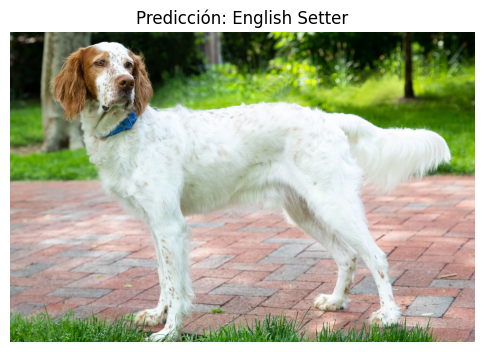

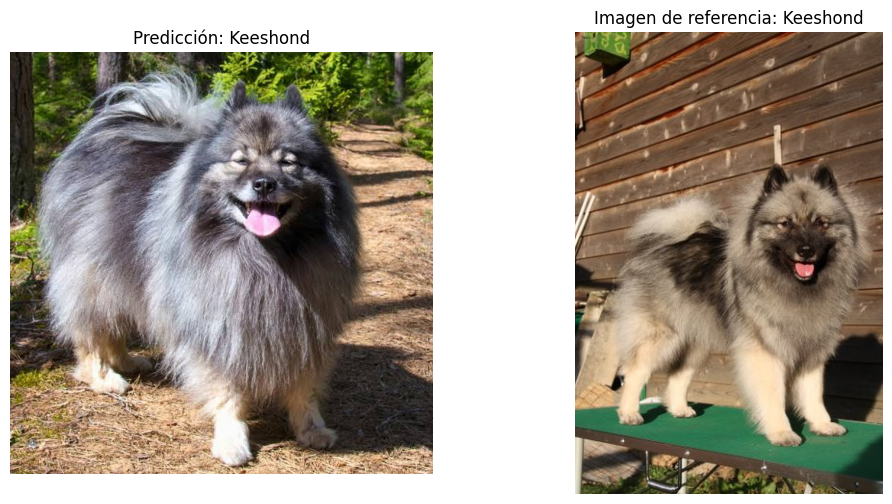

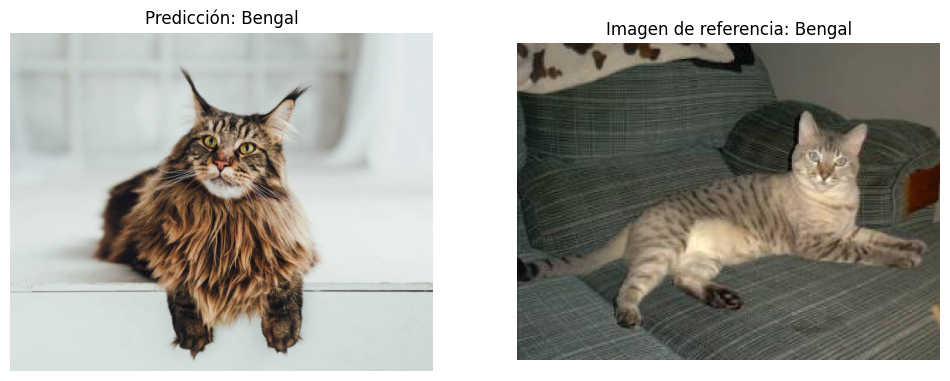

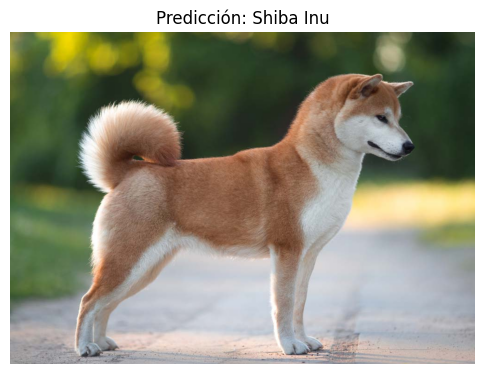

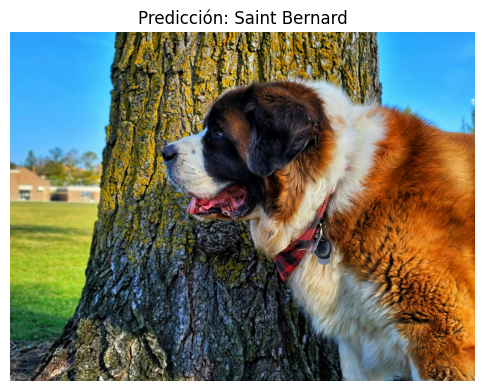

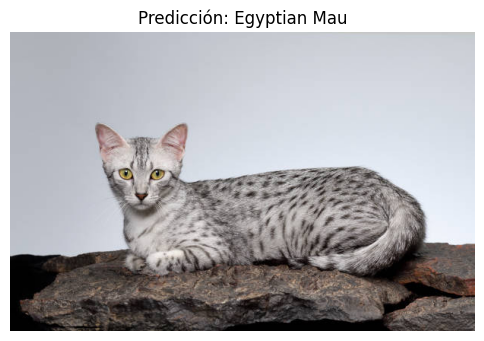

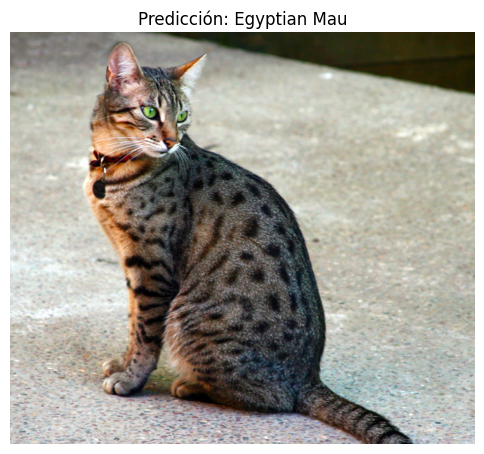

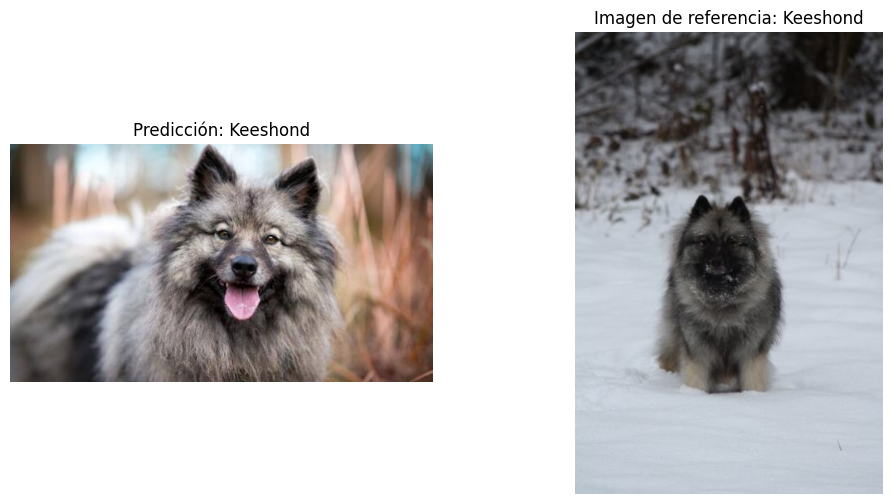

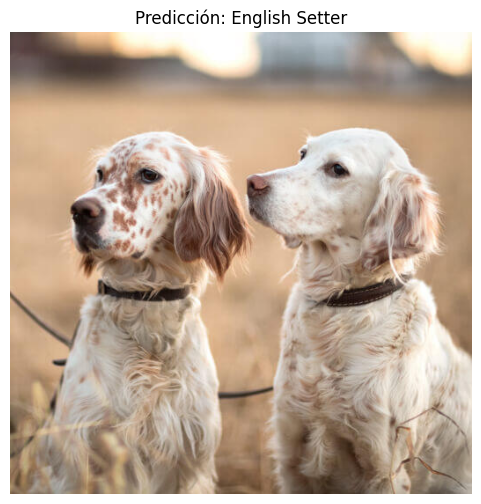

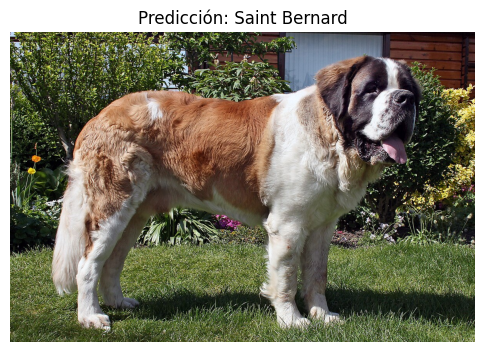

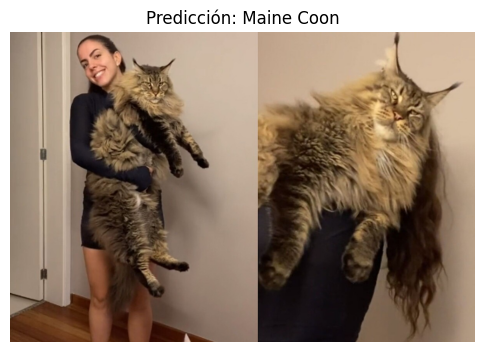

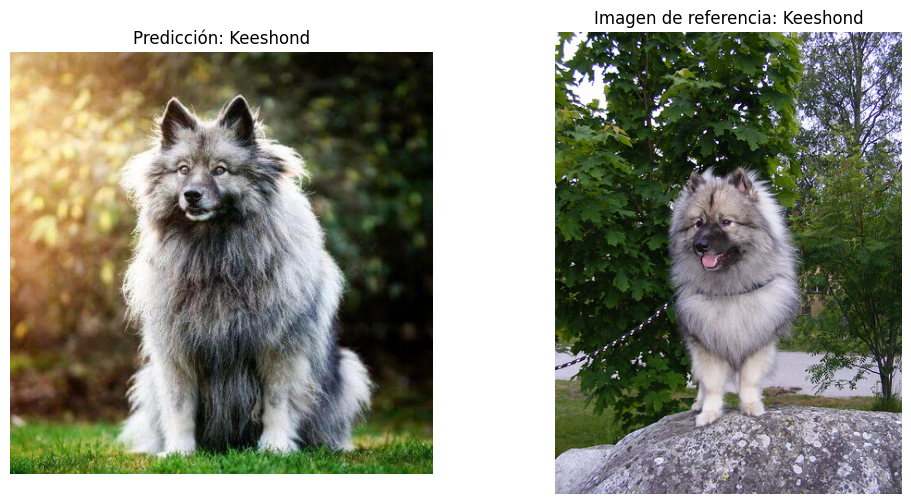

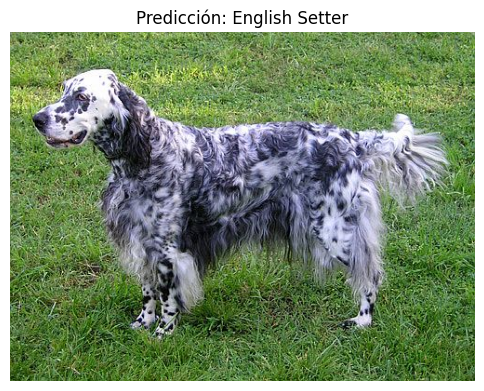

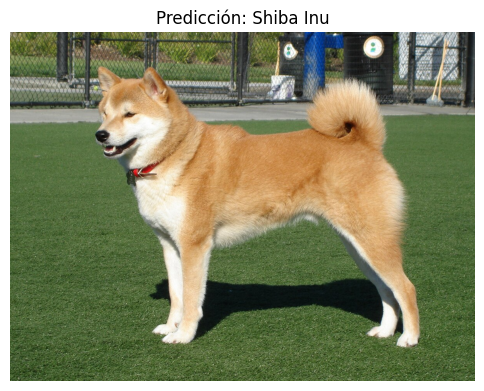

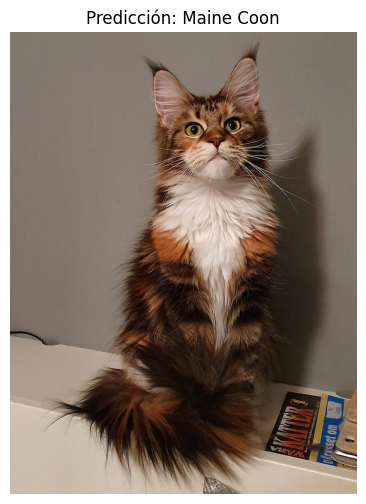

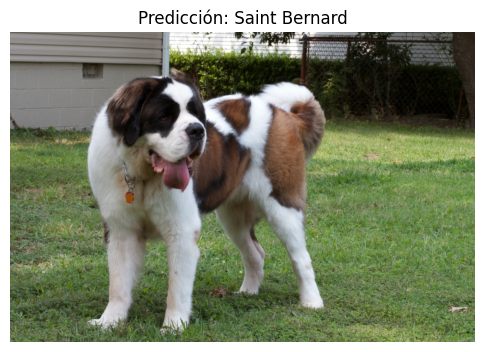

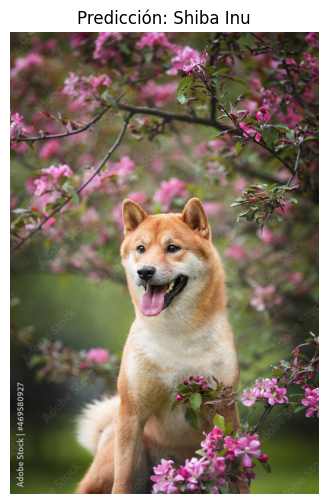


Resumen:
Total de imágenes procesadas: 17
Distribución de predicciones:
Egyptian Mau: 2
Shiba Inu: 3
English Setter: 3
Bengal: 1
Maine Coon: 2
Saint Bernard: 3
Keeshond: 3


In [36]:
import os
import torch
from torchvision import transforms
from torchvision.models import efficientnet_b0
from PIL import Image, ImageDraw, ImageFont
import torch.nn as nn
import matplotlib.pyplot as plt
import random

# Función para mostrar la imagen con predicción
def display_prediction(image_path, predicted_class, reference_image=None):
    if reference_image:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Imagen original
    image = Image.open(image_path).convert('RGB')
    if reference_image:
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title(f"Predicción: {predicted_class}")
    else:
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicción: {predicted_class}")

    # Imagen de referencia
    if reference_image:
        ref_img = Image.open(reference_image).convert('RGB')
        ax[1].imshow(ref_img)
        ax[1].axis('off')
        ax[1].set_title(f"Imagen de referencia: {predicted_class}")

    plt.show()


# Transformaciones para preprocesar la imagen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Clase del modelo (PetBreedClassifier)
class PetBreedClassifier(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        self.backbone = efficientnet_b0(weights=None)  # Sin pesos preentrenados
        num_ftrs = self.backbone.classifier[1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Instanciar el modelo
num_classes = 37
model = PetBreedClassifier(num_classes=num_classes)

# Cargar el modelo preentrenado
model_path = "/home/miguel_mf/projects/ML-Recon-Imag/Best_Non-Segmented_Clasiffier.pth"
try:
    checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Modelo cargado exitosamente.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")

# Clases
classes = [
    'Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 
    'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 
    'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 
    'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 
    'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 
    'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 
    'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 
    'Wheaten Terrier', 'Yorkshire Terrier'
]

# Función para mostrar la imagen con predicción
def display_prediction(image_path, predicted_class, reference_image=None):
    if reference_image:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Imagen original
    image = Image.open(image_path).convert('RGB')
    if reference_image:
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title(f"Predicción: {predicted_class}")
    else:
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicción: {predicted_class}")

    # Imagen de referencia
    if reference_image:
        ref_img = Image.open(reference_image).convert('RGB')
        ax[1].imshow(ref_img)
        ax[1].axis('off')
        ax[1].set_title(f"Imagen de referencia: {predicted_class}")

    plt.show()

# Función para predecir la raza
def predict_breed(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        return None, f"Error: La imagen no se encuentra en la ruta {image_path}"

    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = classes[predicted.item()]
    return predicted_class, None

# Función para obtener una imagen de referencia aleatoria de la misma clase
def get_reference_image(predicted_class, dataset_path):
    class_images = [
        os.path.join(dataset_path, img) 
        for img in os.listdir(dataset_path) if predicted_class.lower() in img.lower()
    ]
    return random.choice(class_images) if class_images else None

# Procesar todas las imágenes en la carpeta
folder_path = "/home/miguel_mf/projects/ML-Recon-Imag/Img_Prueba"
dataset_path = "/home/miguel_mf/projects/ML-Recon-Imag/data/oxford-iiit-pet/images"

results = {}
for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)

    if image_file.lower().endswith(('png', 'jpg', 'jpeg')):
        predicted_class, error = predict_breed(image_path)
        if error:
            print(error)
            continue

        # Obtener imagen de referencia
        reference_image = get_reference_image(predicted_class, dataset_path)

        # Mostrar la predicción visualmente
        display_prediction(image_path, predicted_class, reference_image)

        # Guardar resultados
        results[image_file] = predicted_class

# Resumen
print("\nResumen:")
print(f"Total de imágenes procesadas: {len(results)}")
print(f"Distribución de predicciones:")
predictions_count = {cls: list(results.values()).count(cls) for cls in set(results.values())}
for cls, count in predictions_count.items():
    print(f"{cls}: {count}")


# Explanation of the Image Classification Code

This script implements an image classification pipeline for predicting pet breeds from images. The main tasks include loading a pre-trained model, processing images, making predictions, and displaying the results along with reference images.

---

## **1. Key Components of the Script**

### **Model Definition**
- **PetBreedClassifier**: A custom neural network built on the EfficientNet-B0 backbone, fine-tuned for 37 pet breed classes. 
- The classifier consists of:
  - A dropout layer to prevent overfitting.
  - Fully connected layers to map features to the 37 output classes.
- The model loads a pre-trained checkpoint (`Best_Non-Segmented_Clasiffier.pth`) to make predictions.

---

### **Preprocessing**
- **Transformations**: Input images are resized to 224x224 pixels, converted to tensors, and normalized using standard ImageNet mean and standard deviation values.
- **Purpose**: Ensures the input format matches the model's requirements.

---

### **Functions**

#### **Image Prediction**
- **`predict_breed(image_path)`**:
  - Loads an image and preprocesses it using the defined transformations.
  - Passes the image through the model to predict the class with the highest probability.
  - Returns the predicted class label.

#### **Displaying Results**
- **`display_prediction(image_path, predicted_class, reference_image=None)`**:
  - Displays the input image with the predicted breed label.
  - Optionally, shows a reference image of the same breed for comparison.

#### **Reference Image Retrieval**
- **`get_reference_image(predicted_class, dataset_path)`**:
  - Retrieves a random image of the same predicted class from a dataset folder.
  - Useful for visual comparison and validation.

---

### **Processing Images in a Folder**
- **Folder Path**: The script processes all images in the specified folder (`Img_Prueba`).
- For each image:
  1. Predicts the breed using `predict_breed`.
  2. Retrieves a reference image of the predicted class from the dataset.
  3. Displays the original and reference images side-by-side.
  4. Saves the prediction result in a dictionary for a summary.

---

## **2. Outputs**

### **Prediction Results**
- The script prints:
  - The total number of images processed.
  - The distribution of predicted classes, showing how many times each class was predicted.

### **Visualization**
- Displays images with predicted labels and corresponding reference images, helping users visually validate predictions.

---

## **3. Applications**
This pipeline is ideal for:
- **Pet Breed Classification**: Automating the identification of pet breeds from images.
- **Model Debugging**: Visually comparing predictions with reference images to identify potential misclassifications.
- **Dataset Validation**: Checking for biases or inconsistencies in the model's predictions.

---

## **4. Next Steps for Improvement**
- **Add Error Handling**:
  - Ensure the script skips unsupported file types or missing images gracefully.
- **Enhance Visualization**:
  - Include confidence scores alongside predictions.
- **Metrics**:
  - Calculate overall accuracy, precision, recall, and F1-score to evaluate model performance on the dataset.
- **Model Improvement**:
  - Use pre-trained weights for EfficientNet-B0 to improve accuracy.
  - Perform data augmentation to handle imbalanced classes.

---

## **5. Summary**
This script effectively integrates a custom deep learning model for non-segmented image classification. By combining efficient prediction, visualization, and result summarization, it provides a robust pipeline for pet breed identification.


---

# **Conclusion of the Project**

This project represents the development of a robust and adaptable workflow for pet breed classification using machine learning. The pipeline integrates multiple algorithms to address challenges inherent in real-world datasets, particularly the problem of noisy and cluttered backgrounds in images.

### **Project Goals**
The main objective of this project was to create a **hybrid workflow combining four algorithms** to improve classification accuracy and adaptability. These algorithms include:
1. **Image Segmentation**: Isolate the subject (the pet) from its background to eliminate unnecessary noise.
2. **Segmented Image Classification**: Classify breeds using cleaner, segmented images where only the relevant features (the pet) are present.
3. **Non-Segmented Image Classification**: Provide an alternative path for simpler images or scenarios where segmentation is unnecessary.
4. **Dynamic Algorithm Selection**: Implement a decision-making mechanism to dynamically choose between segmentation and direct classification based on the complexity of the background in each image.

### **Why This Workflow?**
Real-world datasets often contain images with complex and distracting backgrounds. In such cases:
- The model might focus on irrelevant features from the background instead of the subject.
- This background noise reduces the model's ability to accurately identify the pet breed, particularly in environments with high visual variability.

The hybrid workflow was designed to address these issues by allowing the pipeline to adapt dynamically:
- **If the background is simple**, the pipeline directly classifies the image without segmentation, reducing computational overhead.
- **If the background is noisy**, the segmentation algorithm is applied to isolate the subject, improving classification accuracy.

This adaptability ensures that the model performs well in both controlled datasets and real-world environments, making it a practical solution for diverse use cases.

### **Summary of Achievements**
- **Baseline Model Development**: We trained and evaluated a classifier on non-segmented images, achieving solid performance despite the challenges posed by noisy backgrounds.
- **Data Analysis**: We explored the dataset and identified the limitations of using raw, non-segmented images, setting the stage for the hybrid workflow.
- **Dynamic Workflow Proposal**: We outlined the integration of segmentation and classification, with a decision-making mechanism to optimize performance for different scenarios.
- **Future-Ready Design**: The architecture is flexible, allowing the integration of additional algorithms or enhancements, such as advanced segmentation techniques or attention-based mechanisms, to further improve accuracy and efficiency.

### **Future Work**
The next steps for this project involve implementing and refining the segmentation-based classification and dynamic decision-making components. Additionally, the system will be tested in real-world scenarios with highly variable datasets to validate its robustness.

Due to time constraints, we were unable to train the three models fully as originally planned. Specifically:
1. **The Segmentation Model**: While proposed, this remains to be trained and optimized for accurately isolating the subject (the pet) from its background.
2. **The Segmented Image Classification Model**: This also requires future training to handle images that have undergone segmentation.
3. **Dynamic Decision-Making System**: Though conceptually outlined, the logic to dynamically decide between using segmented or non-segmented classification needs to be fully implemented and tested.

However, the **Non-Segmented Image Classification Model** has been successfully trained and validated. It serves as a robust baseline and performs well for images where background noise is not excessively disruptive. This model provides a foundation upon which the full workflow can be built and improved.

Future work will involve training and fine-tuning the segmentation model and the classifier for segmented images, followed by the integration and testing of the complete hybrid workflow. This will ensure a more comprehensive and adaptable solution for pet breed classification in real-world scenarios with complex backgrounds.



# **Animal Breed Classification Project**

## **Project Overview**
This project implements an animal breed classification system using machine learning models. The primary focus is on developing a pipeline that can handle both segmented and non-segmented images to improve classification accuracy in real-world scenarios. The key components of the project include:

- Preprocessing and data augmentation.
- Implementation of a classification model for non-segmented images.
- A planned hybrid pipeline for segmentation and classification to handle noisy backgrounds.

Currently, the non-segmented image classification model has been fully implemented and trained. Due to time constraints, the segmentation-based models remain untrained but are intended for future development.

---

## **Features**

- **Non-Segmented Image Classification**: A trained model capable of accurately predicting animal breeds from raw images.
- **Segmentation-Based Classification Pipeline (Planned)**: Future implementation to combine segmentation and classification for enhanced accuracy.
- **Real-World Applicability**: Designed to handle noisy and diverse backgrounds.

---

## **Setup and Installation**

### **Step 1: Clone the Repository**
```bash
git clone <repository_url>
cd <repository_name>
```

### **Step 2: Set Up Environment**
1. Install Conda if not already installed. You can download it from [Miniconda](https://docs.conda.io/en/latest/miniconda.html).

2. Create a Conda environment:
   ```bash
   conda create -n breed_classifier python=3.10
   conda activate breed_classifier
   ```

3. Install dependencies from `requirements.txt`:
   ```bash
   pip install -r requirements.txt
   ```

### **Step 3: Download Pretrained Model**
The pretrained model for non-segmented image classification can be downloaded from the following link:
[Download Model](<model_download_link>)

Save the model file (`Best_Non-Segmented_Classifier.pth`) in the project directory.

### **Step 4: Prepare the Dataset**
Ensure the dataset is organized as follows:
```
data/
  └── oxford-iiit-pet/
      └── images/
          ├── image1.jpg
          ├── image2.jpg
          └── ...
```
You can download the Oxford-IIIT Pet dataset from [here](https://www.robots.ox.ac.uk/~vgg/data/pets/).

---

## **Usage**

### **Run the Prediction Script**
To process and classify images, place the images in the `Img_Prueba` folder and run the script:
```bash
python script.py
```

The script will:
1. Predict the breed of each image.
2. Optionally display a reference image from the dataset for comparison.
3. Print a summary of predictions and their distribution.

### **Results**
The results, including predicted classes, will be displayed on the console. You can modify the script to save these results in a file if needed.

---

## **Future Work**

- **Train Segmentation-Based Models**: Develop and train models for segmenting noisy images.
- **Pipeline Integration**: Combine segmentation and classification for dynamic decision-making based on image complexity.
- **Performance Evaluation**: Test the system in real-world scenarios with high variability.

---

## **Acknowledgements**

- Oxford-IIIT Pet Dataset.
- PyTorch and torchvision libraries.
- OpenAI for providing tools and support.

---

## **Contributing**
Feel free to fork this repository, raise issues, or submit pull requests to improve the project.

---

## **License**
This project is licensed under the MIT License. See the `LICENSE` file for details.
